In [3]:
import torch
import sys
sys.path.append("../")
from utils import plot_images, save_gif, make_grid_from_temporal_batch, normalize
from denoiser import DDIM
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import torch.nn.functional as F

from glob import glob

from IPython.display import Image as IPythonImage
import IPython.display as display
import ipyplot
import ipywidgets as widgets

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models trained on same dataset

In [14]:
log_name1 = "AFHQ256Exp1_bigger_network"
log_name2 = "AFHQ256Exp1"

ddim1 = DDIM.load_from_training_log(f"../../logs/training/{log_name1}", model_name="ema_model.pt", device=device)
ddim1.eval()
ddim1.to(device);

ddim2 = DDIM.load_from_training_log(f"../../logs/training/{log_name2}", model_name="ema_model.pt", device=device)
ddim2.eval()
ddim2.to(device);

print(ddim1.model.get_model_stored_size())
print(ddim2.model.get_model_stored_size())

Loading model...
Finished testing UNet
Detected potential compatibility issues with model. Attempting to fix...
Fixed 👍
Creating instance of class...
Denoiser initialized
Loading model...
Finished testing UNet
Detected potential compatibility issues with model. Attempting to fix...
Fixed 👍
Creating instance of class...
Denoiser initialized
340.3501091003418
85.0356559753418


In [19]:
latents = torch.randn(8, *ddim1.data_shape).to(device)

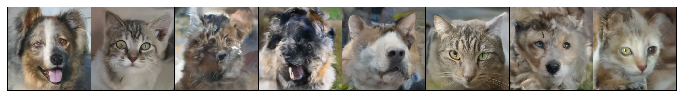

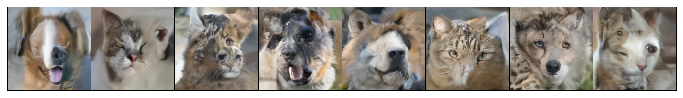

In [20]:
timesteps = 30
ddim1.eta = ddim2.eta = 0

x1 = ddim1.sample(device, timesteps=timesteps, latents=latents)
plot_images((x1+1)/2, clip=True, scale=2)

x2 = ddim2.sample(device, timesteps=timesteps, latents=latents)
plot_images((x2+1)/2, clip=True, scale=2)

In [34]:
for i in range(x1.shape[0]):
    e1 = F.avg_pool2d(x1[i][None, ...].clone(), 3, 3)
    e2 = F.avg_pool2d(x2[i][None, ...].clone(), 3, 3)
    
    save_image((e1+1)/2, f"../../outputs/optimal_transport/same_dataset/{log_name1}_{i}.png")
    save_image((e2+1)/2, f"../../outputs/optimal_transport/same_dataset/{log_name2}_{i}.png")

# Models trained on different datasets
With same data shape

In [21]:
log_name1 = "Celeb256"
log_name2 = "AFHQ256"

ddim1 = DDIM.load_from_training_log(f"../../logs/training/{dropdown1.value}", model_name="ema_model.pt", device=device)
ddim1.eval()
ddim1.to(device);

ddim2 = DDIM.load_from_training_log(f"../../logs/training/{dropdown2.value}", model_name="ema_model.pt", device=device)
ddim2.eval()
ddim2.to(device);

print(ddim1.model.get_model_stored_size())
print(ddim2.model.get_model_stored_size())

Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized
Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized
1577.0520133972168
1577.0520133972168


In [29]:
latents = torch.randn(8, *ddim1.data_shape).to(device)

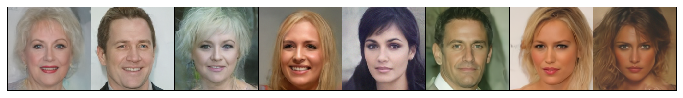

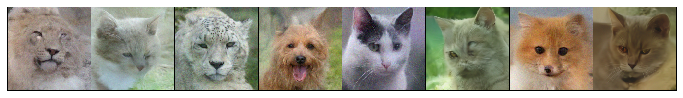

In [30]:
timesteps = 20
ddim1.eta = ddim2.eta = 0
x1 = ddim1.sample(device, timesteps=timesteps, latents=latents)
plot_images((x1+1)/2, clip=True, scale=2)

x2 = ddim2.sample(device, timesteps=timesteps, latents=latents)
plot_images((x2+1)/2, clip=True, scale=2)

In [131]:
for i in range(len(x1)):
    e1 = F.avg_pool2d(x1[i][None, ...].clone(), 2, 2)
    e2 = F.avg_pool2d(x2[i][None, ...].clone(), 2, 2)
    
    save_image((e1+1)/2, f"../../outputs/optimal_transport/different_datasets/celeb_{i}.png")
    save_image((e2+1)/2, f"../../outputs/optimal_transport/different_datasets/animal_{i}.png")

# Models trained on same dataset of different resolutions

In [5]:
log_names = ["pokemoncards256_cont2", "pokemoncards128_cont1", "pokemoncards64"]
models = ["ema_model.pt", "ema_model.pt", "ema_model.pt"]
ddims = []
for name, model in zip(log_names, models):
    d = DDIM.load_from_training_log(f"../../logs/training/{name}", model_name=model, device=device)
    d.eval()
    d.to(device);
    d.eta=0
    ddims.append(d)
    

Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized
Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized
Loading model...
Finished testing UNet
Creating instance of class...
Denoiser initialized


In [86]:
start_noise = torch.randn(1, *ddims[0].data_shape).to(device)


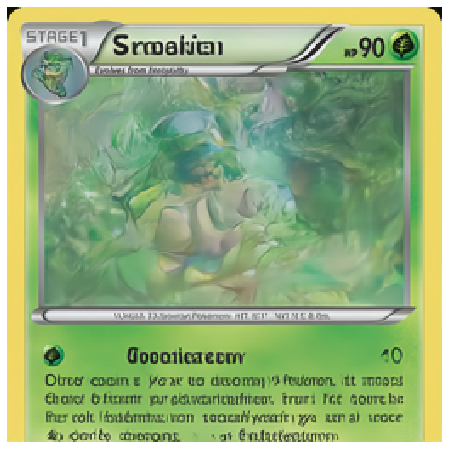

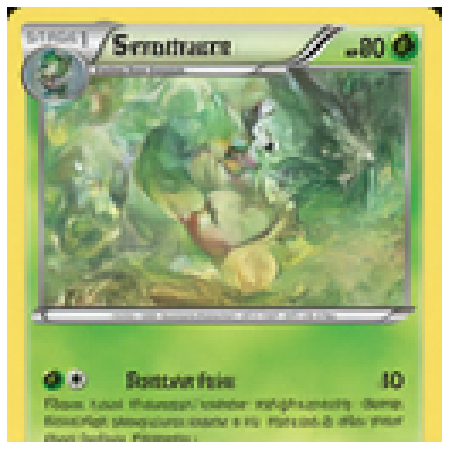

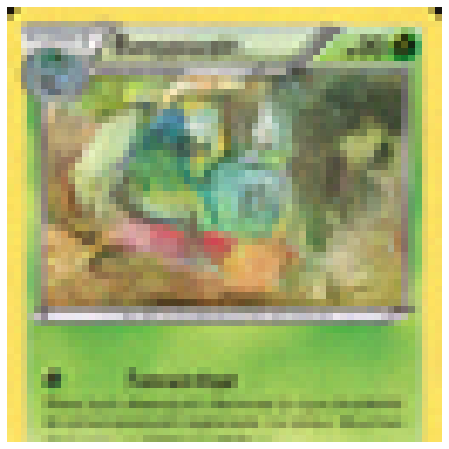

In [87]:
latents = start_noise.clone()
# latents += torch.tensor([[-0.05,-0.05,0.05]])[:, :, None, None].repeat((1, 1, 256, 256)).to(device)
# torch.save(start_noise, "../../outputs/latents/pokemon/pokemonrumble.pt")
xs = []
xTs = []
for d in ddims:
    xTs.append(latents)
    x = d.sample(device, timesteps=20, latents=latents)
    xs.append(x)
    latents = F.avg_pool2d(latents, 2, 2)
#     latents = latents[:, :, ::2, ::2]
#     print(latents.shape)

plot_images((xs[0]+1)/2, clip=True, scale=2)
plot_images((xs[1]+1)/2, clip=True, scale=2)
plot_images((xs[2]+1)/2, clip=True, scale=2)

In [88]:
for i, (x0, xT) in enumerate(zip(xs, xTs)):
    save_image((x0+1)/2, f"../../outputs/optimal_transport/avgpool_latents/x0_{i}.png")
    save_image((xT+1)/2, f"../../outputs/optimal_transport/avgpool_latents/xT_{i}.png")